# **Autoencoders and Variational Autoencoders**
<br> Group 12 
<ul>
<li> Hanin Monir Ismail           192895 </li>
<li> Jacinta Samir                206562 </li>
<li> Youssef Ayman                203800 </li>
</ul>



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers as tfl
import os, random
from PIL import Image, ImageOps
import glob
from keras.utils import image_dataset_from_directory
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from skimage.util import random_noise
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## *Preprocessing the data*

In [ ]:
CelebAImagesPath = '/content/drive/MyDrive/img_align_celeba_10k'
CelebANoisyPath = '/content/drive/MyDrive/img_noisy_celeba_10k'

Exploring the images:

In [ ]:
def plot_images(path):
    W_grid = 4
    L_grid = 2
    fig, axes = plt.subplots(L_grid, W_grid, figsize = (12,6))
    axes = axes.ravel() #flatten into array

    for i in np.arange(0, W_grid * L_grid):
        img = random.choice(os.listdir(path))
        axes[i].imshow(Image.open(os.path.join(path,img)))
        axes[i].axis('off')

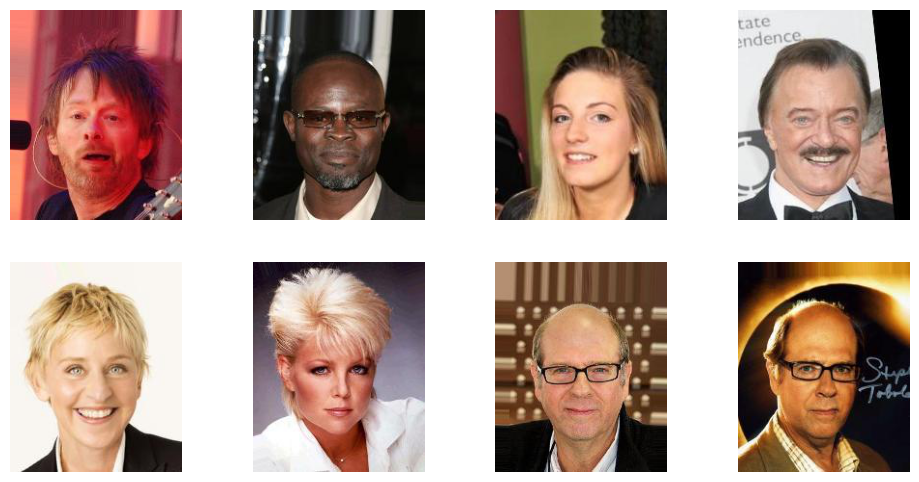

In [ ]:
plot_images(CelebAImagesPath)

In [ ]:
width, height = Image.open(os.path.join(CelebAImagesPath,'000001.jpg')).size

In [ ]:
# x = True

# for img in os.listdir(CelebAImagesPath):
#     w, h = Image.open(os.path.join(CelebAImagesPath,img)).size
#     if w != width or h != height:
#         print("Images are not all the same size!")
#         x = False
#         break
# if x == True:
#     print("Images are all of size:\nWidth: %d\nHeight: %d"%(width,height))

Images are all of size:
Width: 178
Height: 218


The sizes of the images do not need fixing as they are already all equal

### Adding Noise

Gaussian noise was added to create a noisy dataset to be used in the DAE

In [ ]:
def add_noise(img, dest):
    im = np.asarray(img)
    imnoise = random_noise(im)
    noisy = Image.fromarray((imnoise*255).astype(np.uint8))
    noisy.save(dest)   

# for file in os.listdir(CelebAImagesPath):
#     img = Image.open(os.path.join(CelebAImagesPath,file))
#     dest = os.path.join(CelebANoisyPath,file)
#     add_noise(img,dest)

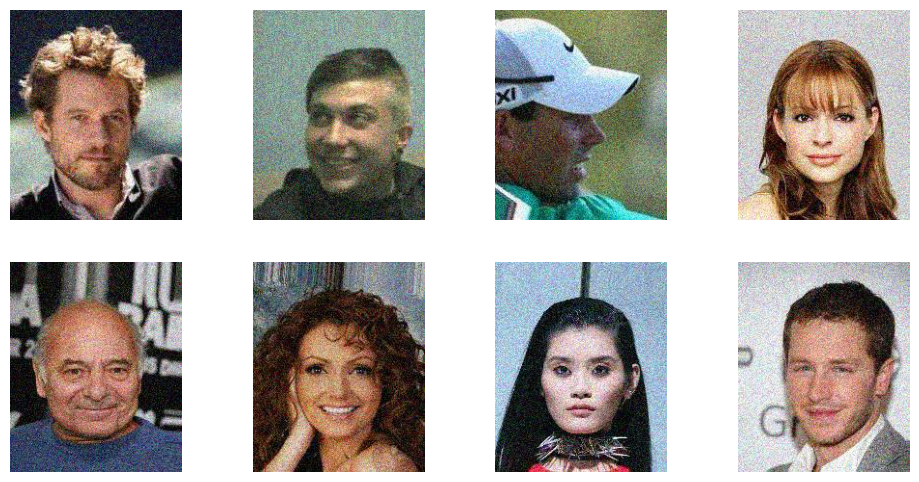

In [ ]:
plot_images(CelebANoisyPath)

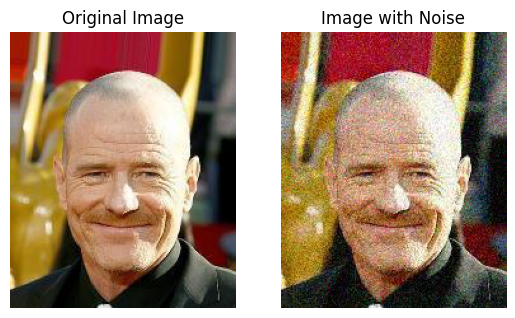

In [ ]:
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(Image.open(os.path.join(CelebAImagesPath,'001655.jpg')))
plt.axis('off')
plt.title("Original Image")
fig.add_subplot(1,2,2)
plt.imshow(Image.open(os.path.join(CelebANoisyPath,'001655.jpg')))
plt.axis('off')
plt.title("Image with Noise")
plt.show()

###Padding

The images need to be padded with 1 pixel all around, as when building the AE, reducing the size of the original images produces odd numbers, and thus when upsampling, the output size becomes slightly larger. Padding is required to ensure equal input and output sizes. 

In [ ]:
def pad_images(path):
    for element in os.listdir(path):
        img = Image.open(os.path.join(path,element))
        newImg = ImageOps.expand(img, border = 1,fill=255)
        newImg.save(os.path.join(path,element))

# pad_images(CelebAImagesPath)
# pad_images(CelebANoisyPath)

In [ ]:
# height += 2
# width +=2

### Forming the Train and Test Sets

The images need to be saved in a numpy array to fit the model using both the clean and noisy images.

In [ ]:
def save_to_array(path):
    images = np.array([np.array(Image.open(os.path.join(path,image))) for image in os.listdir(path)])
    return images

In [ ]:
# nds = save_to_array(CelebANoisyPath)
# ds = save_to_array(CelebAImagesPath)

In [ ]:
def pickle_dump(file, filename):
  with open(filename, 'wb') as f:
    pickle.dump(file, f)
  f.close()

def pickle_load(filename):
  with open(filename, 'rb') as f:
    file = pickle.load(f)
  f.close()
  return file

In [ ]:
# pickle_dump(nds,'nds.pkl')
# pickle_dump(ds,'ds.pkl')

In [ ]:
# nds = pickle_load('nds.pkl')
# ds = pickle_load('ds.pkl')

Normalize:

In [ ]:
# ndsn = nds.astype("float32") / 255
# dsn = ds.astype("float32") / 255

In [ ]:
# pickle_dump(ndsn,'ndsn.pkl')
# pickle_dump(dsn,'dsn.pkl')

In [ ]:
# ndsn = pickle_load('ndsn.pkl')
# dsn = pickle_load('dsn.pkl')

In [ ]:
# ndsn1k = nds[:1000].astype("float32") / 255
# dsn1k = ds[:1000].astype("float32") / 255

In [ ]:
# pickle_dump(ndsn1k,'ndsn1k.pkl')
# pickle_dump(dsn1k,'dsn1k.pkl')

In [ ]:
ndsn1k = pickle_load('ndsn1k.pkl')
dsn1k = pickle_load('dsn1k.pkl')

In [ ]:
print(ndsn.shape)

(10000, 220, 180, 3)


In [ ]:
print(ndsn1k.shape)

(1000, 220, 180, 3)


Train-Test split:

In [ ]:
# nt_ds, nv_ds = ndsn[:6000,:], ndsn[6000:,:]
# t_ds, v_ds = dsn[:6000,:], dsn[6000:-20,:]

In [ ]:
nt_ds1k, nv_ds1k = ndsn1k[:600,:], ndsn1k[600:,:]
t_ds1k, v_ds1k = dsn1k[:600,:], dsn1k[600:,:]

In [ ]:
print(type(nt_ds1k))

<class 'numpy.ndarray'>


## *Denoising using AE*

###Building the DAE

In [ ]:
height = 220
width = 180
BATCH_SIZE = 32

In [ ]:
DAE = tf.keras.models.Sequential()
#Normalizing pixel values
#DAE.add(tfl.Rescaling(1./255, input_shape=(height, width, 3)))
#Input 
DAE.add(keras.Input(shape=(height,width,3)))
#Encoder Architecture
DAE.add(tfl.Conv2D(32, 3, activation='relu', padding='same', strides=2))
DAE.add(tfl.Conv2D(16, 3, activation='relu', padding='same', strides=2))

#Bottleneck [Code Size = (55, 45, 16)]

#Decoder Architecture
DAE.add(tfl.Conv2DTranspose(16, 3, activation='relu', padding='same', strides=2))
DAE.add(tfl.Conv2DTranspose(32, 3, activation='relu', padding='same', strides=2))
#Output
DAE.add(tfl.Conv2D(3, 3, activation='sigmoid', padding='same'))

DAE.compile(loss='binary_crossentropy', optimizer='adam')
DAE.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 90, 32)       896       
                                                                 
 conv2d_1 (Conv2D)           (None, 55, 45, 16)        4624      
                                                                 
 conv2d_transpose (Conv2DTra  (None, 110, 90, 16)      2320      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 220, 180, 32)     4640      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 220, 180, 3)       867       
                                                                 
Total params: 13,347
Trainable params: 13,347
Non-traina

In [ ]:
#DAE.fit(nt_ds1k, t_ds1k, epochs = 10, batch_size = BATCH_SIZE, validation_data = (nv_ds1k, v_ds1k))

Epoch 1/10
19/19 [==============================] - 93s 5s/step - loss: 0.6882 - val_loss: 0.6828
Epoch 2/10
19/19 [==============================] - 94s 5s/step - loss: 0.6823 - val_loss: 0.6809
Epoch 3/10
19/19 [==============================] - 94s 5s/step - loss: 0.6802 - val_loss: 0.6798
Epoch 4/10
19/19 [==============================] - 85s 4s/step - loss: 0.6794 - val_loss: 0.6797
Epoch 5/10
19/19 [==============================] - 100s 5s/step - loss: 0.6792 - val_loss: 0.6788
Epoch 6/10
19/19 [==============================] - 87s 5s/step - loss: 0.6781 - val_loss: 0.6777
Epoch 7/10
19/19 [==============================] - 90s 5s/step - loss: 0.6765 - val_loss: 0.6770
Epoch 8/10
19/19 [==============================] - 85s 5s/step - loss: 0.6755 - val_loss: 0.6751
Epoch 9/10
19/19 [==============================] - 86s 5s/step - loss: 0.6744 - val_loss: 0.6752
Epoch 10/10
19/19 [==============================] - 85s 5s/step - loss: 0.6738 - val_loss: 0.6740


In [ ]:
#pickle_dump(DAE,'DAE.pkl')

In [ ]:
DAE = pickle_load('DAE.pkl')

In [ ]:
evaluation = DAE.evaluate(nv_ds1k, v_ds1k)

13/13 [==============================] - 12s 891ms/step - loss: 0.6740


In [ ]:
print("Testing loss : {:.3f}".format(evaluation))

Testing loss : 0.674


In [ ]:
predictions = DAE.predict(nv_ds1k)

13/13 [==============================] - 12s 918ms/step


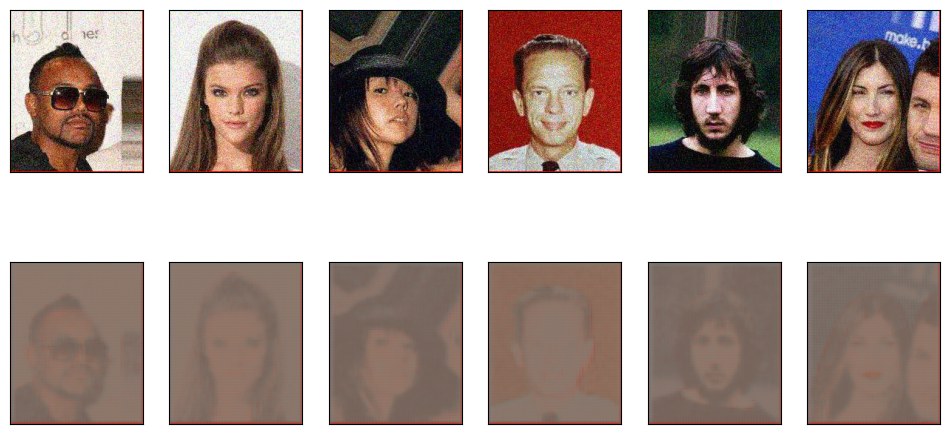

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=6, sharex=True, sharey=True, figsize=(12,6))
for images, row in zip([nv_ds1k[:6], predictions[:6]], axes):
    for img, ax in zip(images, row):
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## *Adding features to faces using VAE*

The main approach we are going to to take is based on the model built by Hou et al found here https://arxiv.org/pdf/1610.00291.pdf 


We are going to add smiles as a feature to faces by calculated a smile vector from all the images with the smile attribute in the dataset, then multiplying the smile vector with a smile factor and adding the result to the emdedding in the latent space, then feeding the result to the decoder.

For this VAE model we are going to load the full dataset from tensorflow along with its attributes. Then, resize the images to 128x128 and normalize its values.

*Most of the cells were run on a separate notebook and screenshot of the output added, because they failed to run in this notebook*

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np
from tensorflow import keras
from tensorflow.keras import Model, Sequential, metrics, optimizers
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D,\
                                    MaxPooling2D, UpSampling2D, GlobalAveragePooling2D,\
                                    Layer, Lambda,Flatten, Reshape, Conv2DTranspose,\
                                    Activation, LeakyReLU, Dropout, InputLayer
import tensorflow.keras.backend as K
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers

from keras.layers import Conv2DTranspose
from keras.losses import binary_crossentropy

In [ ]:
# Load CelebA dataset using tfds builder
celeba_builder = tfds.builder('celeb_a')
celeba_builder.download_and_prepare()
celeba_train = celeba_builder.as_dataset(split='train', shuffle_files=True)
celeba_test = celeba_builder.as_dataset(split='test', shuffle_files=True)

# Resize images to 128x128
def resize_image(image):
    image = tf.image.resize(image, (128, 128))
    # Normalize pixel values to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Apply image resizing and attributes extraction function
celeba_train = celeba_train.map(lambda x: (resize_image(x['image']), x['attributes']))

In [ ]:
type(celeba_train)

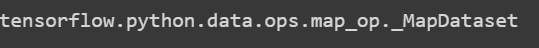

In [ ]:
# Display number of images in the training set
train_count = celeba_train.cardinality().numpy()
print("Number of images in the training set: ", train_count)

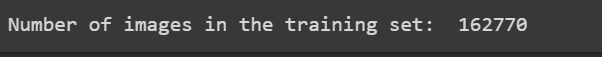

In [ ]:
# Display number of images in the training set
test_count = celeba_test.cardinality().numpy()
print("Number of images in the training set: ", test_count)

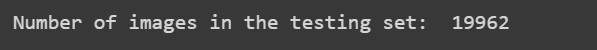

Caculating the smile vectors

In [ ]:

def calculate_smile_vector(images):
    # Filter images with "smile" attribute
    def filter_smile(x):
        return x['attributes']['Smiling']

    smile_images = images.filter(filter_smile)

    # Convert dataset to list of images
    smile_images = [x['image'] for x in smile_images]

    # Convert list of images to numpy array
    smile_train_images = np.array(tf.keras.preprocessing.image.stack_imglist(smile_images))

    # Calculate mean vector for smiling images
    smile_vector = np.mean(smile_train_images, axis=0)

    return smile_vector

def calculate_non_smile_vector(images):
    # Filter images with "smile" attribute
    def filter_non_smile(x):
        return tf.math.logical_not(x['attributes']['Smiling'])

    non_smile_images = images.filter(filter_non_smile)

    # Convert dataset to list of images
    non_smile_images = [x['image'] for x in non_smile_images]

    # Convert list of images to numpy array
    non_smile_train_images = np.array(tf.keras.preprocessing.image.stack_imglist(non_smile_images))

    # Calculate mean vector for non-smiling images
    non_smile_vector = np.mean(non_smile_train_images, axis=0)

    return non_smile_vector


Building the VAE model 

The encoder and the sampling space:

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim = 100 #@param {type:"slider", min:50, max:150, step:10}

encoder_inputs = keras.Input(shape=(128,128, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 65536)        0           ['conv2d_1[0][0]']         

The decoder:

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=4, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=4, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 128, 32)     18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 128, 3)      867 

In [ ]:
# A function to compute the value of latent space
def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

vae = Model(encoder_inputs, decoder_outputs, name='vae')

# Compute the VAE loss
reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(encoder_inputs, decoder_outputs), axis=(1, 2, 3))
kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
vae_loss = reconstruction_loss + kl_loss

# Compile the VAE model
vae.add_loss(vae_loss)


In [ ]:
epochs = 10 #@param {type:"slider", min:1, max:10, step:1}
batch = 64 #@param {type:"slider", min:8, max:128, step:8}

vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(celeba_train, epochs=epochs, batch_size=batch)

##Making people smile

In [ ]:
smile_factor = 0.1 #@param {type:"slider", min:-1, max:1, step:0.1}

image, _ = next(iter(celeba_test.batch(1)))
smile_vector = calculate_smile_vector(images)

encoded_imgs = vae.predict(image)
encoded_imgs = encoded_imgs + smile_factor * smile_vector
decoded_imgs = decoder.predict(encoded_imgs)
n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(celeba_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()